In [1]:
%matplotlib inline
from astropy.table import Table
from astropy.io import fits as pf
import pylab as p
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from matplotlib import cm
cool_cmap = cm.hot_r
cool_cmap.set_under('w')

In [2]:
#Now we read OD maps and systematics maps for 0.2 sq degree (NSIDE=128) pixles. we apply regression in different redshift bins
#Using the coefficients we make PD maps in different redshift bins.

OD_55_z_60 = np.loadtxt('cats/Lrg_obs_density_55_z_60_map.in')
OD_60_z_65 = np.loadtxt('cats/Lrg_obs_density_60_z_65_map.in')
OD_65_z_70 = np.loadtxt('cats/Lrg_obs_density_65_z_70_map.in')
OD_70_z_75 = np.loadtxt('cats/Lrg_obs_density_70_z_75_map.in')
OD_75_z_85 = np.loadtxt('cats/Lrg_obs_density_75_z_85_map.in')
OD_z_85    = np.loadtxt('cats/Lrg_obs_density_z_85_map.in')

#Read all the maps in arrays for regression.
w1_covMed_map_p2  = hp.fitsfunc.read_map("../Lrg_healpy/wise_sys/wise_sys_map_p2_NN.fits", field=0, hdu=1, h=False, verbose=True, memmap=False)
w1_Med_map_p2     = hp.fitsfunc.read_map("../Lrg_healpy/wise_sys/wise_sys_map_p2_NN.fits", field=1, hdu=1, h=False, verbose=True, memmap=False)
w1_moonlev_map_p2 = hp.fitsfunc.read_map("../Lrg_healpy/wise_sys/wise_sys_map_p2_NN.fits", field=2, hdu=1, h=False, verbose=True, memmap=False)

PSF_FWHM_z_map_p2 = hp.fitsfunc.read_map("../Lrg_healpy/sdss_sys/sdss_sys_map_p2.fits", field=0, hdu=1, h=False, verbose=True, memmap=False)
skyflux_z_map_p2  = hp.fitsfunc.read_map("../Lrg_healpy/sdss_sys/sdss_sys_map_p2.fits", field=1, hdu=1, h=False, verbose=True, memmap=False)
r_ext_map_p2      = hp.fitsfunc.read_map("../Lrg_healpy/sdss_r_ext_map_p2.fits", field=0, hdu=1, h=False, verbose=True, memmap=False)

star_map_05 = np.loadtxt("../Lrg_healpy//sdss_sys/allstars17.519.9Healpixall256.dat")
star_map_p2 = hp.pixelfunc.ud_grade(star_map_05,nside_out=128, pess= True)

sdss_footprint_p2 = np.where(skyflux_z_map_p2 > 0)

w1_covMed_map_p2[np.isnan(w1_covMed_map_p2)]=-0
w1_Med_map_p2[np.isnan(w1_Med_map_p2)]=-0
w1_moonlev_map_p2[np.isnan(w1_moonlev_map_p2)] = -0

PSF_FWHM_z_map_p2[np.isnan(PSF_FWHM_z_map_p2)] = -0.0
skyflux_z_map_p2[np.isnan(skyflux_z_map_p2)]   = -0.0
r_ext_map_p2[np.isnan(r_ext_map_p2)] =-0.0

star_map_p2[np.isnan(star_map_p2)] = -0.0

print len(OD_55_z_60), len(OD_60_z_65), len(OD_65_z_70), len(OD_70_z_75), len(OD_75_z_85 ),len(OD_z_85)

/Users/abhi/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/healpy/pixelfunc.py:270: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/abhi/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:26: RuntimeWarning: invalid value encountered in greater


NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
196608 196608 196608 196608 196608 196608


In [3]:
#Regression variables systematics.
rv_w1_covMed_p2  = w1_covMed_map_p2[sdss_footprint_p2]
rv_w1_moonlev_p2 = w1_moonlev_map_p2[sdss_footprint_p2]
rv_w1_Med_p2     = w1_Med_map_p2[sdss_footprint_p2]

rv_r_ext_p2     = 10**r_ext_map_p2[sdss_footprint_p2]
rv_z_psf_p2     = PSF_FWHM_z_map_p2[sdss_footprint_p2]
rv_z_skyflux_p2 = skyflux_z_map_p2[sdss_footprint_p2]

rv_star_map_p2  = star_map_p2[sdss_footprint_p2]

#prepare for regression
X_rv = np.column_stack((rv_w1_covMed_p2, rv_w1_moonlev_p2, rv_w1_Med_p2,rv_star_map_p2, rv_r_ext_p2, rv_z_psf_p2, rv_z_skyflux_p2))
print "done"

done


In [4]:
#Now we do regression in every bin, one by one and make PD maps.
lrg_od_55_z_60 = OD_55_z_60[:,3][sdss_footprint_p2]
#print len(lrg_od_55_z_60), min(lrg_od_55_z_60), max(lrg_od_55_z_60), len(w1_covMed_map_p2), len(rv_w1_covMed_p2)


# now we build regression models using linear regression from Scikit learn
from sklearn import linear_model
clf_55_z_60 = linear_model.LinearRegression(fit_intercept=True )
clf_55_z_60.fit(X_rv,lrg_od_55_z_60)
print clf_55_z_60.coef_,clf_55_z_60.intercept_
print "done"

[ -1.34815575e-03   6.11758815e-02  -1.48270689e-02   7.71472692e-06
  -8.97512508e-02  -3.86088431e-01   8.01868046e-03] 1.7389677435
done


In [5]:
lrg_od_60_z_65 = OD_60_z_65[:,3][sdss_footprint_p2]
from sklearn import linear_model
clf_60_z_65 = linear_model.LinearRegression(fit_intercept=True )
clf_60_z_65.fit(X_rv,lrg_od_60_z_65)
print clf_60_z_65.coef_,clf_60_z_65.intercept_
print "done"

[ -4.55796342e-04  -8.78664556e-02  -3.89697154e-02   2.47583349e-05
  -1.12258766e-01  -4.97975559e-01   1.22245712e-02] 2.89410988808
done


In [6]:
lrg_od_65_z_70 = OD_65_z_70[:,3][sdss_footprint_p2]
from sklearn import linear_model
clf_65_z_70 = linear_model.LinearRegression(fit_intercept=True )
clf_65_z_70.fit(X_rv,lrg_od_65_z_70)
print clf_65_z_70.coef_,clf_65_z_70.intercept_
print "done"

[  1.03973149e-03   3.08354499e-02  -4.26474420e-02   1.68099432e-05
  -1.02760979e-01  -4.02493207e-01   1.13721505e-02] 3.18600104427
done


In [7]:
lrg_od_70_z_75 = OD_70_z_75[:,3][sdss_footprint_p2]
from sklearn import linear_model
clf_70_z_75 = linear_model.LinearRegression(fit_intercept=True )
clf_70_z_75.fit(X_rv,lrg_od_70_z_75)
print clf_70_z_75.coef_,clf_70_z_75.intercept_
print "done"

[  1.03489991e-03   1.01236363e-01  -2.83612167e-03  -2.00060394e-05
   1.07887276e-01  -3.70162089e-02   1.89042851e-02] 2.03592474394
done


In [8]:
lrg_od_75_z_85 = OD_75_z_85[:,3][sdss_footprint_p2]
from sklearn import linear_model
clf_75_z_85 = linear_model.LinearRegression(fit_intercept=True )
clf_75_z_85.fit(X_rv,lrg_od_75_z_85)
print clf_75_z_85.coef_,clf_75_z_85.intercept_
print "done"

[  1.96765991e-03   1.89208515e-01   3.53760145e-02   2.50015371e-05
   3.76438619e-01   6.17162146e-01   3.06534519e-02] 0.539013667103
done


In [9]:
lrg_od_z_85 = OD_z_85[:,3][sdss_footprint_p2]
from sklearn import linear_model
clf_z_85 = linear_model.LinearRegression(fit_intercept=True )
clf_z_85.fit(X_rv,lrg_od_z_85)
print clf_z_85.coef_,clf_z_85.intercept_
print "done"

[  1.09002704e-03   3.54404918e-02   1.82691899e-02   8.06170761e-06
   1.90019639e-01   2.76276532e-01   8.64619244e-03] -0.13856453652
done


In [10]:
w1_covMed_map_01  = hp.fitsfunc.read_map("../Lrg_healpy/wise_sys/wise_sys_map_p01_NN.fits", field=0, hdu=1, h=False, verbose=True, memmap=False)
w1_Med_map_01     = hp.fitsfunc.read_map("../Lrg_healpy/wise_sys/wise_sys_map_p01_NN.fits", field=1, hdu=1, h=False, verbose=True, memmap=False)
w1_moonlev_map_01 = hp.fitsfunc.read_map("../Lrg_healpy/wise_sys/wise_sys_map_p01_NN.fits", field=2, hdu=1, h=False, verbose=True, memmap=False)

PSF_FWHM_z_map_01 = hp.fitsfunc.read_map("../Lrg_healpy/sdss_sys/sdss_sys_map_p01.fits", field=0, hdu=1, h=False, verbose=True, memmap=False)
skyflux_z_map_01  = hp.fitsfunc.read_map("../Lrg_healpy/sdss_sys/sdss_sys_map_p01.fits", field=1, hdu=1, h=False, verbose=True, memmap=False)
r_ext_map_01      = hp.fitsfunc.read_map("../Lrg_healpy/sdss_sys/sdss_sys_map_p01.fits", field=2, hdu=1, h=False, verbose=True, memmap=False)


w1_covMed_map_01[np.isnan(w1_covMed_map_01)]=-0
w1_Med_map_01[np.isnan(w1_Med_map_01)]=-0
w1_moonlev_map_01[np.isnan(w1_moonlev_map_01)] = -0

PSF_FWHM_z_map_01[np.isnan(PSF_FWHM_z_map_01)] = -0.0
skyflux_z_map_01[np.isnan(skyflux_z_map_01)]   = -0.0
r_ext_map_01[np.isnan(r_ext_map_01)] =-0.0


star_map_p01 = hp.pixelfunc.ud_grade(star_map_05,nside_out=512, pess= True)


#theta_map_05 [np.isnan(theta_map_05)] =-99.0

#lrgs_obs_den_map_05[np.isnan(lrgs_obs_den_map_05)]=-0.0


print len(skyflux_z_map_01[~np.isnan(skyflux_z_map_01)]), len(skyflux_z_map_01[np.where(skyflux_z_map_01 > 0)])

print "done"

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
3145728 834480
done


In [11]:
sdss_footprint_01 = np.where(skyflux_z_map_01 > 0)


rv_w1_covMed_01  = w1_covMed_map_01[sdss_footprint_01]
rv_w1_moonlev_01 = w1_moonlev_map_01[sdss_footprint_01]
rv_w1_Med_01     = w1_Med_map_01[sdss_footprint_01]

rv_r_ext_01      = 10**r_ext_map_01[sdss_footprint_01]
rv_z_psf_01      = PSF_FWHM_z_map_01[sdss_footprint_01]
rv_z_skyflux_01  = skyflux_z_map_01[sdss_footprint_01]
#rv_theta_01      = 1.0/np.sin(theta_map_01[sdss_footprint_01])
star_map_p01 = hp.pixelfunc.ud_grade(star_map_05,nside_out=512, pess= True)

rv_star_map_01  = star_map_p01[sdss_footprint_01]
print "done"

done


In [12]:
constant_55_z_60 = clf_55_z_60.intercept_*(np.zeros(len(rv_w1_covMed_01))+1.0)

lrgs_pd_55_z_60  = constant_55_z_60+ clf_55_z_60.coef_[0]*rv_w1_covMed_01 +  clf_55_z_60.coef_[1] *rv_w1_moonlev_01 + clf_55_z_60.coef_[2]*rv_w1_Med_01 + clf_55_z_60.coef_[3] *rv_star_map_01 + clf_55_z_60.coef_[4]*rv_r_ext_01 + clf_55_z_60.coef_[5]*rv_z_psf_01 + clf_55_z_60.coef_[6]*rv_z_skyflux_01 
print "done"

done


In [13]:
NSIDE_p01 = 512
Pd_55_z_60 = np.zeros(hp.nside2npix(NSIDE_p01))
Pd_55_z_60[sdss_footprint_01] = lrgs_pd_55_z_60
print "done"

done


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


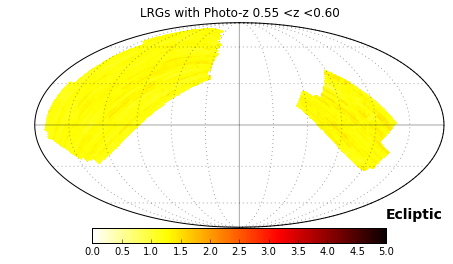

In [14]:
hp.visufunc.mollview(Pd_55_z_60,coord=['G','E'],title="LRGs with Photo-z 0.55 <z <0.60",max =5,min =0.0,cmap=cool_cmap,cbar=None)
#hp.visufunc.mollview(pz_85,coord=['G','E'],title="LRGs with Photo-z >0.85",max =2,min =0,cmap=cool_cmap, cbar=None)
hp.graticule(alpha = 0.35)
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cmap = fig.colorbar(image, ax=ax, orientation="horizontal",shrink=0.5,anchor=(0.5,2.90))
plt.savefig('plots/Lrg predicted density 0.55 <z <0.60.pdf')

np.savetxt('cats/Lrg_pre_density_55_z_60_map.in', np.c_[Pd_55_z_60], header='Predicted Density (0.55 <z <0.60)')

In [15]:
constant_60_z_65 = clf_60_z_65.intercept_*(np.zeros(len(rv_w1_covMed_01))+1.0)

lrgs_pd_60_z_65  = constant_60_z_65+ clf_60_z_65.coef_[0]*rv_w1_covMed_01 +  clf_60_z_65.coef_[1] *rv_w1_moonlev_01 + clf_60_z_65.coef_[2]*rv_w1_Med_01 + clf_60_z_65.coef_[3] *rv_star_map_01 + clf_60_z_65.coef_[4]*rv_r_ext_01 + clf_60_z_65.coef_[5]*rv_z_psf_01 + clf_60_z_65.coef_[6]*rv_z_skyflux_01
print "done"

done


In [16]:
Pd_60_z_65 = np.zeros(hp.nside2npix(NSIDE_p01))
Pd_60_z_65[sdss_footprint_01] = lrgs_pd_60_z_65
print "done"

done


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
done


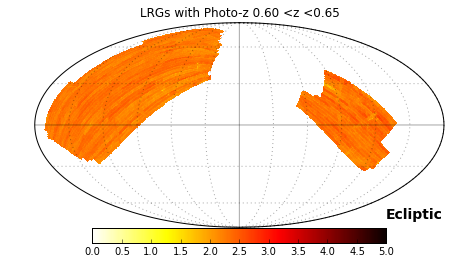

In [17]:
hp.visufunc.mollview(Pd_60_z_65,coord=['G','E'],title="LRGs with Photo-z 0.60 <z <0.65",max =5,min =0.0,cmap=cool_cmap,cbar=None)
#hp.visufunc.mollview(pz_85,coord=['G','E'],title="LRGs with Photo-z >0.85",max =2,min =0,cmap=cool_cmap, cbar=None)
hp.graticule(alpha = 0.35)
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cmap = fig.colorbar(image, ax=ax, orientation="horizontal",shrink=0.5,anchor=(0.5,2.90))
plt.savefig('plots/Lrg predicted density 0.60 <z <0.65.pdf')

np.savetxt('cats/Lrg_pre_density_60_z_65_map.in', np.c_[Pd_60_z_65], header='Predicted Density (0.60 <z <0.65)')

print "done"

In [18]:
constant_65_z_70 = clf_65_z_70.intercept_*(np.zeros(len(rv_w1_covMed_01))+1.0)

lrgs_pd_65_z_70  = constant_65_z_70+ clf_65_z_70.coef_[0]*rv_w1_covMed_01 +  clf_65_z_70.coef_[1] *rv_w1_moonlev_01 + clf_65_z_70.coef_[2]*rv_w1_Med_01 + clf_65_z_70.coef_[3] *rv_star_map_01 + clf_65_z_70.coef_[4]*rv_r_ext_01 + clf_65_z_70.coef_[5]*rv_z_psf_01 + clf_65_z_70.coef_[6]*rv_z_skyflux_01
print "done"

done


In [19]:
Pd_65_z_70 = np.zeros(hp.nside2npix(NSIDE_p01))
Pd_65_z_70[sdss_footprint_01] = lrgs_pd_65_z_70
print "done"

done


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
done


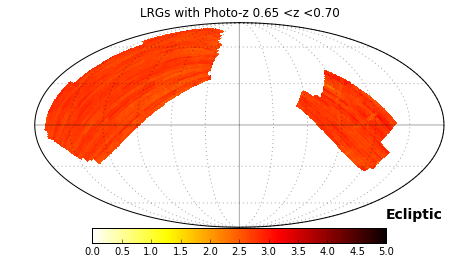

In [20]:
hp.visufunc.mollview(Pd_65_z_70,coord=['G','E'],title="LRGs with Photo-z 0.65 <z <0.70",max =5,min =0.0,cmap=cool_cmap,cbar=None)
#hp.visufunc.mollview(pz_85,coord=['G','E'],title="LRGs with Photo-z >0.85",max =2,min =0,cmap=cool_cmap, cbar=None)
hp.graticule(alpha = 0.35)
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cmap = fig.colorbar(image, ax=ax, orientation="horizontal",shrink=0.5,anchor=(0.5,2.90))
plt.savefig('plots/Lrg predicted density 0.65<z<0.70.pdf')

np.savetxt('cats/Lrg_pre_density_65_z_70_map.in', np.c_[Pd_65_z_70], header='Predicted Density (0.65 <z <0.70)')
print "done"

In [21]:
constant_70_z_75 = clf_70_z_75.intercept_*(np.zeros(len(rv_w1_covMed_01))+1.0)

lrgs_pd_70_z_75  = constant_70_z_75+ clf_70_z_75.coef_[0]*rv_w1_covMed_01 +  clf_70_z_75.coef_[1] *rv_w1_moonlev_01 + clf_70_z_75.coef_[2]*rv_w1_Med_01 + clf_70_z_75.coef_[3] *rv_star_map_01 + clf_70_z_75.coef_[4]*rv_r_ext_01 + clf_70_z_75.coef_[5]*rv_z_psf_01 + clf_70_z_75.coef_[6]*rv_z_skyflux_01
print "done"

done


In [22]:
Pd_70_z_75 = np.zeros(hp.nside2npix(NSIDE_p01))
Pd_70_z_75[sdss_footprint_01] = lrgs_pd_70_z_75
print "done"

done


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
done


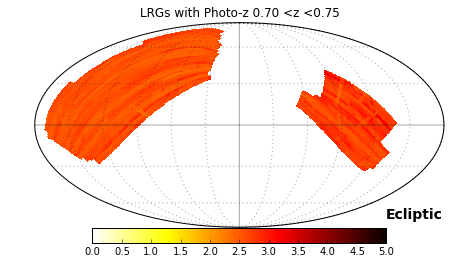

In [23]:
hp.visufunc.mollview(Pd_70_z_75,coord=['G','E'],title="LRGs with Photo-z 0.70 <z <0.75",max =5,min =0.0,cmap=cool_cmap,cbar=None)
#hp.visufunc.mollview(pz_85,coord=['G','E'],title="LRGs with Photo-z >0.85",max =2,min =0,cmap=cool_cmap, cbar=None)
hp.graticule(alpha = 0.35)
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cmap = fig.colorbar(image, ax=ax, orientation="horizontal",shrink=0.5,anchor=(0.5,2.90))
plt.savefig('plots/Lrg predicted density 0.70 <z <0.75.pdf')

np.savetxt('cats/Lrg_pre_density_70_z_75_map.in', np.c_[Pd_70_z_75], header='Predicted Density (0.70 <z <0.75)')
print "done"

In [24]:
constant_75_z_85 = clf_75_z_85.intercept_*(np.zeros(len(rv_w1_covMed_01))+1.0)

lrgs_pd_75_z_85  = constant_75_z_85+ clf_75_z_85.coef_[0]*rv_w1_covMed_01 +  clf_75_z_85.coef_[1] *rv_w1_moonlev_01 + clf_75_z_85.coef_[2]*rv_w1_Med_01 + clf_75_z_85.coef_[3] *rv_star_map_01 + clf_75_z_85.coef_[4]*rv_r_ext_01 + clf_75_z_85.coef_[5]*rv_z_psf_01 + clf_75_z_85.coef_[6]*rv_z_skyflux_01
print "done"

done


In [25]:
Pd_75_z_85 = np.zeros(hp.nside2npix(NSIDE_p01))
Pd_75_z_85[sdss_footprint_01] = lrgs_pd_75_z_85
print "done"

done


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
done


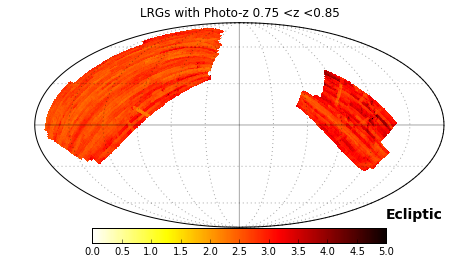

In [26]:
hp.visufunc.mollview(Pd_75_z_85,coord=['G','E'],title="LRGs with Photo-z 0.75 <z <0.85",max =5,min =0.0,cmap=cool_cmap,cbar=None)
#hp.visufunc.mollview(pz_85,coord=['G','E'],title="LRGs with Photo-z >0.85",max =2,min =0,cmap=cool_cmap, cbar=None)
hp.graticule(alpha = 0.35)
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cmap = fig.colorbar(image, ax=ax, orientation="horizontal",shrink=0.5,anchor=(0.5,2.90))
plt.savefig('plots/Lrg predicted density z 0.75 <z <0.85.pdf')

np.savetxt('cats/Lrg_pre_density_75_z_85_map.in', np.c_[Pd_75_z_85], header='Predicted Density (0.75 <z <0.85)')
print "done"

In [27]:
constant_z_85 = clf_z_85.intercept_*(np.zeros(len(rv_w1_covMed_01))+1.0)

lrgs_pd_z_85  = constant_z_85+ clf_z_85.coef_[0]*rv_w1_covMed_01 +  clf_z_85.coef_[1] *rv_w1_moonlev_01 + clf_z_85.coef_[2]*rv_w1_Med_01 + clf_z_85.coef_[3] *rv_star_map_01 + clf_z_85.coef_[4]*rv_r_ext_01 + clf_z_85.coef_[5]*rv_z_psf_01 + clf_z_85.coef_[6]*rv_z_skyflux_01
print "done"

done


In [28]:
Pd_z_85 = np.zeros(hp.nside2npix(NSIDE_p01))
Pd_z_85[sdss_footprint_01] = lrgs_pd_z_85
print "done"

done


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
done


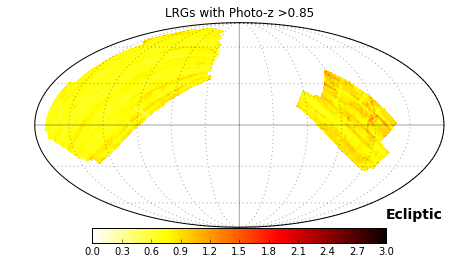

In [29]:
hp.visufunc.mollview(Pd_z_85,coord=['G','E'],title="LRGs with Photo-z >0.85",max =3,min =0.0,cmap=cool_cmap,cbar=None)
#hp.visufunc.mollview(pz_85,coord=['G','E'],title="LRGs with Photo-z >0.85",max =2,min =0,cmap=cool_cmap, cbar=None)
hp.graticule(alpha = 0.35)
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cmap = fig.colorbar(image, ax=ax, orientation="horizontal",shrink=0.5,anchor=(0.5,2.90))
plt.savefig('plots/Lrg predicted density z >0.85.pdf')

np.savetxt('cats/Lrg_pre_density_z_85_map.in', np.c_[Pd_z_85], header='Predicted Density (z > 0.85)')
print "done"